In [22]:
# Bad subjects
# Bad IDs: 605515760919, 601983541597

print(train[311])
print(train[407])

{'meta': {'AgeInMonths': 150, 'Gender': 'M', 'Ethnicity': 'CAUCASIAN/WHITE', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '472', 'nback': '489', 'emoid': '246', 'ID': 605515760919}
{'meta': {'AgeInMonths': 232, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 4, 'AgeGroupEdge1': 216, 'AgeGroupEdge2': 272}, 'rest': '171', 'nback': '176', 'emoid': '180', 'ID': 601983541597}


In [231]:
# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split3.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

467
155
{'meta': {'AgeInMonths': 110, 'Gender': 'M', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '765', 'nback': '790', 'emoid': '554', 'ID': 608665596582}


In [266]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]
test_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [176]:
subj = train_nback[0]

print(subj[0,:]@subj[0,:].T)
print(train_cor[1][0,0])

230.99999999999997
0.9999999999999994


In [267]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
#         if np.sum(np.isnan(subj)) > 0:
#             print(i)
#         if np.sum(np.isinf(subj)) > 0:
#             print(i)

normalizeSubjects(train_ts)
normalizeSubjects(test_ts)

print('Complete')

Complete


In [268]:
# Derive connectivity matrices
# Also create labels (ages)

train_cor = [subj@subj.T/subj.shape[1] for subj in train_ts]
test_cor = [subj@subj.T/subj.shape[1] for subj in test_ts]

X_train_cor = np.vstack([subj.flatten() for subj in train_cor])
X_test_cor = np.vstack([subj.flatten() for subj in test_cor])

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


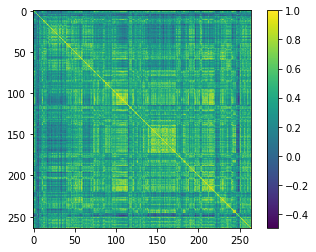

In [269]:
import matplotlib.pyplot as plt

plt.imshow(train_cor[0])
plt.colorbar()
plt.show()

In [270]:
# Linear regression

w1 = np.linalg.lstsq(X_train_cor, y_train, rcond=None)[0]

print('Complete')

Complete


In [271]:
y1 = X_train_cor@w1
mseTrain = (1/len(y_train))*np.sum((y_train - y1)**2)

y2 = X_test_cor@w1
mseTest = (1/len(y_test))*np.sum((y_test - y2)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.00 years
Test error: 2.17 years


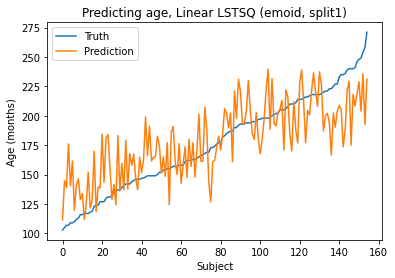

In [272]:
import matplotlib.pyplot as plt

idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y2[idcs], label='Prediction')
plt.title('Predicting age, Linear LSTSQ (emoid, split1)')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()

In [273]:
# Third degree polynomial

def makePolynomial(X, degree):
    d = X.shape[1]
    Xpoly = np.zeros([X.shape[0], d*degree])
    for i in range(degree):
        Xpoly[:,i*d:(i+1)*d] = X**(i+1)
    return Xpoly

Xpoly_train = makePolynomial(X_train_cor, 3)
Xpoly_test = makePolynomial(X_test_cor, 3)

print('Complete')

Complete


In [274]:
print(X_train_cor[0,0:100])
print(Xpoly_train[0,0:100])

[ 1.          0.49624185  0.14268455  0.10238063  0.21361958  0.09743368
  0.34584233  0.06584704  0.18626191 -0.11769798  0.28097249  0.07246722
  0.38323821  0.20230372  0.33031613 -0.01596352  0.09222363  0.13577455
  0.06170297  0.01863205  0.32085013  0.16498174  0.11462102  0.0394325
  0.10326694  0.17885176  0.0131145   0.19866161  0.11443583  0.26461098
 -0.00820537  0.19017109  0.12592665  0.13759183 -0.0863303   0.1923668
  0.04175195  0.13262214  0.19600134 -0.06258341  0.2060412   0.25491696
  0.14902915  0.32580982  0.25084122  0.25978793  0.1886509   0.1602864
  0.03504324  0.0983745   0.15095991  0.10095387  0.25813037  0.28555421
  0.02878847  0.25919716  0.08239322  0.23728155  0.19780762  0.15534577
  0.09069524  0.09431486  0.22456696  0.16200672  0.24028472  0.27811269
  0.09375881  0.14065581 -0.01911294  0.09903561  0.21859193  0.25331188
  0.10531115  0.36840389  0.40072     0.31479806  0.31900364  0.38585838
  0.403091    0.20129593  0.29370862 -0.00848832  0.03

In [275]:
# Polynomial regression

w2 = np.linalg.lstsq(Xpoly_train, y_train, rcond=None)[0]

print('Complete')

Complete


In [276]:
y3 = Xpoly_train@w2
mseTrain = (1/len(y_train))*np.sum((y_train - y3)**2)

y4 = Xpoly_test@w2
mseTest = (1/len(y_test))*np.sum((y_test - y4)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.00 years
Test error: 2.06 years


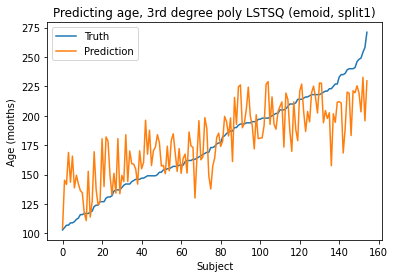

In [277]:
idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y4[idcs], label='Prediction')
plt.title('Predicting age, 3rd degree poly LSTSQ (emoid, split1)')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()

In [206]:
# MLP

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class MLPSingle(nn.Module):
    def __init__(self):
        super(MLPSingle, self).__init__()
        self.fc1 = nn.Linear(264*264,30)
        self.fc2 = nn.Linear(30,1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [278]:
mlpSingle = MLPSingle()
optimSingle = torch.optim.SGD(mlpSingle.parameters(), momentum=0.5, lr=5e-6)
print('Single complete')

Single complete


In [279]:
N = X_train_cor.shape[0]-1
running = 0

for epoch in range(10000):
    # Choose subject
    idx = random.randint(0,N)
    subj = torch.from_numpy(X_train_cor[idx,:]).float()
    truth = y_train[idx,0]
    
    # Train
    optimSingle.zero_grad()
    age = mlpSingle(subj)
    loss = (truth-age)**2
    loss.backward()
    
    # Backpropagate
    optimSingle.step()
    
    running += loss

    # print statistics
    if epoch % 100 == 0:    
        print('[epoch {:d}] loss: {:f}'.format(epoch, ((running[0]/100)**0.5)/12))
        running = 0

print('Finished Training')

[epoch 0] loss: 1.525061
[epoch 100] loss: 7.720538
[epoch 200] loss: 3.387922
[epoch 300] loss: 3.619713
[epoch 400] loss: 3.185038
[epoch 500] loss: 2.901896
[epoch 600] loss: 3.363091
[epoch 700] loss: 3.171810
[epoch 800] loss: 2.831950
[epoch 900] loss: 2.943804
[epoch 1000] loss: 2.354318
[epoch 1100] loss: 2.398589
[epoch 1200] loss: 2.257624
[epoch 1300] loss: 2.206949
[epoch 1400] loss: 2.208656
[epoch 1500] loss: 2.230133
[epoch 1600] loss: 2.120733
[epoch 1700] loss: 2.006003
[epoch 1800] loss: 2.083503
[epoch 1900] loss: 1.922478
[epoch 2000] loss: 1.859277
[epoch 2100] loss: 2.024059
[epoch 2200] loss: 2.122791
[epoch 2300] loss: 1.865941
[epoch 2400] loss: 2.049553
[epoch 2500] loss: 1.683746
[epoch 2600] loss: 1.937169
[epoch 2700] loss: 1.947042
[epoch 2800] loss: 1.871839
[epoch 2900] loss: 1.621586
[epoch 3000] loss: 1.882719
[epoch 3100] loss: 1.766522
[epoch 3200] loss: 1.699682
[epoch 3300] loss: 1.258517
[epoch 3400] loss: 1.651175
[epoch 3500] loss: 1.411777
[epo

In [280]:
def getResults(mlp, X_subjects):
    y = np.zeros([X_subjects.shape[0],1])
    for i in range(X_subjects.shape[0]):
        subj = torch.from_numpy(X_subjects[i,:]).float()
        age = mlp(subj)
        y[i] = int(age)
    return y

y5 = getResults(mlpSingle, X_train_cor)
y6 = getResults(mlpSingle, X_test_cor)

mseTrain = (1/len(y_train))*np.sum((y_train - y5)**2)
mseTest = (1/len(y_test))*np.sum((y_test - y6)**2)

print('Training error:  {:.2f} years'.format(np.sqrt(mseTrain)/12))
print('Test error: {:.2f} years'.format(np.sqrt(mseTest)/12))

Training error:  0.32 years
Test error: 2.15 years


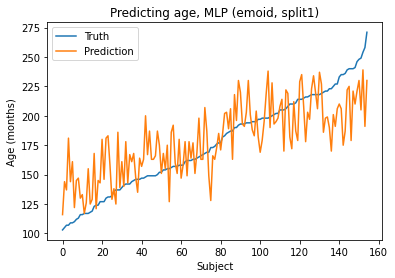

In [281]:
idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y6[idcs], label='Prediction')
plt.title('Predicting age, MLP (emoid, split1)')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()

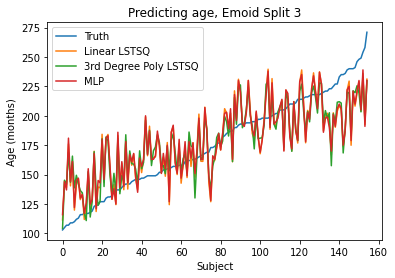

In [282]:
idcs = np.argsort(y_test.flatten())

plt.plot(y_test[idcs], label='Truth')
plt.plot(y2[idcs], label='Linear LSTSQ')
plt.plot(y4[idcs], label='3rd Degree Poly LSTSQ')
plt.plot(y6[idcs], label='MLP')
plt.title('Predicting age, Emoid Split 3')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (months)')
plt.show()